<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/Evaluation_CNN_DOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm # Progress bar
import sklearn
plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Evaluating Accuracy

In [3]:
%cd /content/drive/MyDrive/Github/CNN_DOA/model/

/content/drive/MyDrive/Github/CNN_DOA/model


In [4]:
## Load the model 
model = keras.models.load_model('modelRes30')

In [8]:
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/TEST/RES30

/content/drive/MyDrive/Github/CNN_DOA/Dataset/TEST/RES30


In [9]:
# Extract audio data from a given list of filepaths assuming ordering wrt mics and sources
def extractAudiodata(filepaths, sample_len):
  sourcesDim = int(len(filepaths)/4)
  audioSignals = np.zeros([int(sample_len), 4, sourcesDim])
  sourceIDs = np.zeros([sourcesDim, 1])
  labels30 = np.zeros(sourceIDs.shape)
  labels10 = np.zeros(sourceIDs.shape)

  j = 0 # Indexing sources
  for i in tqdm(range(0, len(filepaths), 4)): # Indexing samples
    micsABCD = filepaths[i:i+4]

    # CHECKS ARE COMPUTATIONALLY DEMANDING
    # Checking if all microphones are present using the mic ID (A,B,C and D)
    #micIDs = [id.split('-')[-4] for id in micsABCD]
    #print(micIDs)
    #if micIDs != ['A', 'B', 'C', 'D']:
      #raise Exception("Filepaths are not ordered or aligned")

    # Checking if all the selected sample are from the same source using the source ID (from 0 to 5999 for the train dataset)
    #currentSourceIDs = [id.split('-')[-3] for id in micsABCD]
    #print(sourceIDs)
    #if len([True for id in currentSourceIDs if id == currentSourceIDs[0]]) != 4:
      #raise Exception("Filepaths are not ordered or aligned")
 
    for k in range(0, len(micsABCD)): # Indexing mics
      audioSignals[:, k, j] = librosa.load(micsABCD[k], sr=None)[0]

    fileid = micsABCD[0].split('.wav')[-2]
    sourceIDs[j] = fileid.split('-')[-3]
    labels30[j] = fileid.split('-')[-2]
    labels10[j] = fileid.split('-')[-1]
    j += 1


  return audioSignals, sourceIDs, labels30, labels10

In [10]:
# Get list of audio files in the current folder
audiofiles_test = [str(file) for file in Path().glob('SA*.wav')]
#print((audiofiles_test))

# Diminuisco un attimo la dimensione del dataset per gestirlo più velocemente
#audiofiles_test = audiofiles_test[:100]

sr = 16000
duration = 0.5

testAudioMatrix, testSourceIDs, testLabels30, testLabels10 = extractAudiodata(audiofiles_test, sr*duration) # Full load took 14 mins

100%|██████████| 120/120 [00:03<00:00, 31.25it/s]


In [11]:
# Checking correct labeling
for i in range(0, 10):
  print('{} with id {}: \n Label resolution 30° --> {}     Label resolution 10° --> {}'.format(audiofiles_test[i*4], int(testSourceIDs[i]), int(testLabels30[i]), int(testLabels10[i])))

SA0-A-0-0-0.wav with id 0: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA4-A-1-0-0.wav with id 1: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA8-A-2-0-0.wav with id 2: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA12-A-3-0-0.wav with id 3: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA16-A-4-0-0.wav with id 4: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA20-A-5-0-0.wav with id 5: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA24-A-6-0-0.wav with id 6: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA28-A-7-0-0.wav with id 7: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA32-A-8-0-0.wav with id 8: 
 Label resolution 30° --> 0     Label resolution 10° --> 0
SA36-A-9-0-0.wav with id 9: 
 Label resolution 30° --> 0     Label resolution 10° --> 0


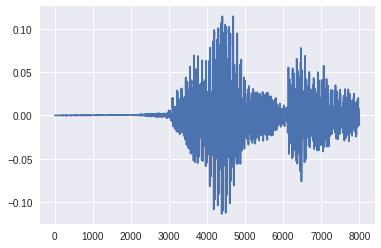

In [14]:
ipd.display(ipd.Audio(testAudioMatrix[:,0,0], rate=sr))
plt.plot(testAudioMatrix[:,0,0])

In [15]:
def computeSI(X1, X2, X3, freqsMatrix, isOblique=False, X4=0,  d=0.04, rho=1.225, beta=1e6):
  denominator = (freqsMatrix + np.finfo(np.float32).eps)*d*rho

  if isOblique:
    X0 = (X1 + X2 + X3) / 3
    V1 = (np.sqrt(2)*1j*(X2 - X1)) / denominator
    V2 = (np.sqrt(2)*1j*(X2 - X3)) / denominator
  else:
    X0 = (X1 + X2 + X3 + X4) / 4
    V1 = (1j*(X3 - X1)) / denominator
    V2 = (1j*(X4 - X2)) / denominator

  W = (np.abs(X0)**2 + beta*(np.abs(V1)**2 + np.abs(V2)**2) )**0.5

  I1 = (np.real(X0*np.conj(V1)) / W).T
  I2 = (np.real(X0*np.conj(V2)) / W).T

  matrix = np.zeros([I1.shape[0], I1.shape[1], 2])
  matrix[:, :, 0] = I1
  matrix[:, :, 1] = I2

  #print('{} --> {}'.format(matrix[:,0,0], matrix[:,-1,0]))
  return matrix

In [16]:
def featureExtractor2(micSignals, d=0.04, rho=1.225, NFFT=1024, sr=16000, beta=1e6):
  frame_length = NFFT
  hop_length = int(frame_length/2) 
  num_samples = micSignals[:,0].shape[0]
  num_frames = int(1 + np.floor((num_samples - frame_length) / hop_length))
  freqs = librosa.fft_frequencies(sr=sr, n_fft=NFFT) #/ (sr/2) * np.pi # Frequency, normalized, angular?
  #freqs = np.flip(freqs)
  freqs = np.reshape(freqs, (len(freqs),1))
  freqsMatrix = np.tile(freqs, (1, num_frames))
  #print(freqsMatrix)

  gamma = np.zeros([num_frames, int(NFFT/2 - 1), 10])
  #print(gamma.shape)

  P1 = librosa.stft(micSignals[:,0], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P2 = librosa.stft(micSignals[:,1], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P3 = librosa.stft(micSignals[:,2], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P4 = librosa.stft(micSignals[:,3], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)

  # Principal directions
  gamma[:,:,0:2] = computeSI(P1, P2, P3, freqsMatrix, isOblique=False, X4=P4, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2] # Using : last index is excluded
  
  # Subarrays
  gamma[:,:,2:4]  = computeSI(P4, P1, P2, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,4:6]  = computeSI(P1, P2, P3, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,6:8]  = computeSI(P2, P3, P4, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,8:10] = computeSI(P3, P4, P1, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]

  return gamma

In [17]:
testAudioMatrix.shape
datapointsNum = testAudioMatrix.shape[-1]
Gamma_container = np.zeros([datapointsNum, 14, 511, 10])
print(Gamma_container.shape)

for i in tqdm(range(0, datapointsNum)):
  Gamma_container[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

(120, 14, 511, 10)


  0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
100%|██████████| 120/120 [00:01<00:00, 115.76it/s]


In [18]:
type(Gamma_container)

numpy.ndarray

In [19]:
# Check how model performs on test dataset
test_loss, test_acc = model.evaluate(Gamma_container,  testLabels30, verbose=2)

print('\nTest accuracy:', test_acc)

4/4 - 2s - loss: 4.6608 - accuracy: 0.0833 - 2s/epoch - 619ms/step

Test accuracy: 0.0833333358168602


In [24]:
model_metrics = model.metrics_names

print('\nModel Metrics:', model_metrics)


Model Metrics: ['loss', 'accuracy']


## Predictions

In [25]:
# Predictions over test set
fast_predictions = model(Gamma_container, training = False)
predictions = model.predict(Gamma_container)


In [26]:
# Show result
audio_idx = 0 # Idx of image
for i in range(len(predictions)):
  print('Model output:',predictions[audio_idx])
  print('Model fast output:',fast_predictions[audio_idx])
  print('Predicted label:', np.argmax(predictions[audio_idx]))
  print('Fast Predicted label:', np.argmax(fast_predictions[audio_idx]))
  print('Ground truth label:',testLabels30[audio_idx])

Model output: [5.1216319e-02 5.1716525e-02 9.9306077e-02 1.2220725e-07 1.4834571e-01
 4.9920276e-02 1.5111107e-01 9.8402902e-02 1.5021625e-01 5.0331540e-02
 1.3024921e-07 1.4942931e-01 1.6052066e-07 1.8398379e-07 1.4971519e-07
 1.7889414e-07 1.2745217e-07 1.8234738e-07 1.3253610e-07 1.6669918e-07
 1.8186303e-07 1.6662131e-07 1.3509370e-07 1.5210274e-07 1.4461601e-07
 1.3631424e-07 1.4319245e-07 1.5191920e-07 1.2114988e-07 1.6372613e-07
 1.8483514e-07 1.5201834e-07 1.2817743e-07 1.5983323e-07 1.4509718e-07
 1.9489909e-07]
Model fast output: tf.Tensor(
[5.1216319e-02 5.1716525e-02 9.9306077e-02 1.2220725e-07 1.4834571e-01
 4.9920276e-02 1.5111107e-01 9.8402902e-02 1.5021625e-01 5.0331540e-02
 1.3024921e-07 1.4942931e-01 1.6052066e-07 1.8398379e-07 1.4971519e-07
 1.7889414e-07 1.2745217e-07 1.8234738e-07 1.3253610e-07 1.6669918e-07
 1.8186303e-07 1.6662131e-07 1.3509370e-07 1.5210274e-07 1.4461601e-07
 1.3631424e-07 1.4319245e-07 1.5191920e-07 1.2114988e-07 1.6372613e-07
 1.8483514e-07 1.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [27]:
10*507*64

324480

In [ ]:
num_rows = 5
num_cols = 3
num_audio = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_audio):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_audio)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()